## The plan

1. Get some data about which airports people fly between, and how many people fly.
1. Get some data about where those airports are, because people generally want to travel between cities, not airports
1. Join this data together, so we know which cities people are travelling between.
1. Get some data about how long train journeys take between those cities.
1. Identify which journeys would be suitable for high-speed sleeper services
1. Do some fancy visualisations.

In [345]:
# Installing libraries

# !pipenv install pandas
# !pipenv install ciso8601
# !pipenv install sqlalchemy 
# !pipenv install records
# !pipenv install seaborn
# !pipenv install chart_studio
!pipenv install geopy

Installing geopy…
Adding geopy to Pipfile's [packages]…
✔ Installation Succeeded 
Pipfile.lock (bb0b4e) out of date, updating to (fad228)…
Locking [dev-packages] dependencies…
Locking [packages] dependencies…
✔ Success! 
Updated Pipfile.lock (bb0b4e)!
Installing dependencies from Pipfile.lock (bb0b4e)…
  🐍   ▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉▉ 76/76 — 00:00:30mmmmmmmmmmmmmmmmmmmmmmmmmmmmmmm


In [2]:
# Importing libraries

import ciso8601
import datetime
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import records
import requests
import seaborn
import sqlite3

from geopy.distance import geodesic
from sqlalchemy import create_engine
from urllib.request import urlretrieve

%config InlineBackend.figure_formats = ['svg']

In [3]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.express as px
MAPBOX_ACCESS_TOKEN = "pk.eyJ1Ijoia2VlbGFuZmgiLCJhIjoiY2sxODgzNjlpMWpnOTNkcGZ6MncxbGk1NyJ9.iHwe8a-cuG1m6EPZf9QszA"

First, we're going to need to download some data about air travel in Europe. [Wikipedia](https://en.wikipedia.org/wiki/List_of_busiest_passenger_air_routes#Europe) is a good place to start, but they only cover the busiest ten routes, so we'll have to go back to the [source data](https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&dir=data) from Eurostat.

In [2]:
# Being lazy about this - just copied from the Eurostat website and let's make them into a nice list for retrieval

file_names = """avia_par_at.tsv.gz
 avia_par_be.tsv.gz
 avia_par_bg.tsv.gz
 avia_par_ch.tsv.gz
 avia_par_cy.tsv.gz
 avia_par_cz.tsv.gz
 avia_par_de.tsv.gz
 avia_par_dk.tsv.gz
 avia_par_ee.tsv.gz
 avia_par_el.tsv.gz
 avia_par_es.tsv.gz
 avia_par_fi.tsv.gz
 avia_par_fr.tsv.gz
 avia_par_hr.tsv.gz
 avia_par_hu.tsv.gz
 avia_par_ie.tsv.gz
 avia_par_is.tsv.gz
 avia_par_it.tsv.gz
 avia_par_lt.tsv.gz
 avia_par_lu.tsv.gz
 avia_par_lv.tsv.gz
 avia_par_me.tsv.gz
 avia_par_mk.tsv.gz
 avia_par_mt.tsv.gz
 avia_par_nl.tsv.gz
 avia_par_no.tsv.gz
 avia_par_pl.tsv.gz
 avia_par_pt.tsv.gz
 avia_par_ro.tsv.gz
 avia_par_se.tsv.gz
 avia_par_si.tsv.gz
 avia_par_sk.tsv.gz
 avia_par_tr.tsv.gz
 avia_par_uk.tsv.gz""".split("\n\xa0")

In [3]:
# Just checking that everything is here

file_names

['avia_par_at.tsv.gz',
 'avia_par_be.tsv.gz',
 'avia_par_bg.tsv.gz',
 'avia_par_ch.tsv.gz',
 'avia_par_cy.tsv.gz',
 'avia_par_cz.tsv.gz',
 'avia_par_de.tsv.gz',
 'avia_par_dk.tsv.gz',
 'avia_par_ee.tsv.gz',
 'avia_par_el.tsv.gz',
 'avia_par_es.tsv.gz',
 'avia_par_fi.tsv.gz',
 'avia_par_fr.tsv.gz',
 'avia_par_hr.tsv.gz',
 'avia_par_hu.tsv.gz',
 'avia_par_ie.tsv.gz',
 'avia_par_is.tsv.gz',
 'avia_par_it.tsv.gz',
 'avia_par_lt.tsv.gz',
 'avia_par_lu.tsv.gz',
 'avia_par_lv.tsv.gz',
 'avia_par_me.tsv.gz',
 'avia_par_mk.tsv.gz',
 'avia_par_mt.tsv.gz',
 'avia_par_nl.tsv.gz',
 'avia_par_no.tsv.gz',
 'avia_par_pl.tsv.gz',
 'avia_par_pt.tsv.gz',
 'avia_par_ro.tsv.gz',
 'avia_par_se.tsv.gz',
 'avia_par_si.tsv.gz',
 'avia_par_sk.tsv.gz',
 'avia_par_tr.tsv.gz',
 'avia_par_uk.tsv.gz']

We'll download all the files first, so that we don't have to keep retrieving them.

In [4]:
os.mkdir('eurostat_avia')
for file_name in file_names:
    urlretrieve(f"https://ec.europa.eu/eurostat/estat-navtree-portlet-prod/BulkDownloadListing?sort=1&downfile=data%2F{file_name}",
                   f"eurostat_avia/{file_name}")

In [6]:
tables = []

for file_name in os.listdir('eurostat_avia'):
    path = os.path.join('eurostat_avia', file_name)
    with gzip.open(path, 'r') as f:
        tables.append(pd.read_csv(f, sep='\t'))

Now I can use the nice `concat` function to merge all these tables together. `concat` will handle all the business of matching up missing columns etc. by name.

In [7]:
merged = pd.concat(tables, sort=True)

In [8]:
merged

,1993,1993M01,1993M02,1993M03,1993M04,1993M05,1993M06,1993M07,1993M08,1993M09,...,2019M04,2019M05,2019M06,2019M07,2019M08,2019M09,2019Q1,2019Q2,2019Q3,"unit,tra_meas,airp_pr\time"
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,:,:,:,NaN,NaN,NaN,:,:,NaN,"FLIGHT,CAF_PAS,EE_EETN_AT_LOWW"
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,78,78,91,NaN,NaN,NaN,221,247,NaN,"FLIGHT,CAF_PAS,EE_EETN_BE_EBBR"
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,:,:,:,NaN,NaN,NaN,:,:,NaN,"FLIGHT,CAF_PAS,EE_EETN_BG_LBWN"
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,:,:,:,NaN,NaN,NaN,:,:,NaN,"FLIGHT,CAF_PAS,EE_EETN_CZ_LKPR"
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,42,44,44,NaN,NaN,NaN,52,130,NaN,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDB"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5932,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,:,NaN,NaN,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX"
5933,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,:,NaN,NaN,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPF"
5934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,:,NaN,NaN,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPH"
5935,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,:,NaN,NaN,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPK"


There are lots of weird marks in cells that have missing data - let's replace them all with NaN for consistency.

In [9]:
merged.replace(': ', np.nan, inplace=True)

We're only really looking for one year's worth of data - let's see which one is the most complete.

In [10]:
merged.count().tail(50)

2016Q2                         87730
2016Q3                         87425
2016Q4                         87176
2017                           92469
2017M01                        82220
2017M02                        82133
2017M03                        87202
2017M04                        91487
2017M05                        92634
2017M06                        93100
2017M07                        93007
2017M08                        92995
2017M09                        93131
2017M10                        91352
2017M11                        84218
2017M12                        81753
2017Q1                         88078
2017Q2                         94210
2017Q3                         93348
2017Q4                         91729
2018                           98883
2018M01                        88592
2018M02                        88520
2018M03                        95539
2018M04                        98275
2018M05                        99924
2018M06                       100190
2

Looks like there are some issues with some missing data. Let's go for the 2017 data.

In [11]:
merged[['unit,tra_meas,airp_pr\\time', '2017 ']]

,"unit,tra_meas,airp_pr\time",2017
0,"FLIGHT,CAF_PAS,EE_EETN_AT_LOWW",709
1,"FLIGHT,CAF_PAS,EE_EETN_BE_EBBR",980
2,"FLIGHT,CAF_PAS,EE_EETN_BG_LBWN",NaN
3,"FLIGHT,CAF_PAS,EE_EETN_CZ_LKPR",NaN
4,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDB",NaN
...,...,...
5932,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX",45720
5933,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPF",NaN
5934,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPH",NaN
5935,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGPK",NaN


First, let's make a copy and get rid of all the other columns. The data looks reasonably good, although there are some missing bits, and the first column is quite messy and will need some unpacking.

In [12]:
clean = merged[['unit,tra_meas,airp_pr\\time', '2017 ']].copy()

In [13]:
clean['unit'], clean['tra_meas'], clean['route'] = clean['unit,tra_meas,airp_pr\\time'].str.split(",", n = 3).str

Now we'll get rid of all the rows with NaN in them.

In [14]:
clean.dropna(inplace=True)

In [15]:
clean

,"unit,tra_meas,airp_pr\time",2017,unit,tra_meas,route
0,"FLIGHT,CAF_PAS,EE_EETN_AT_LOWW",709,FLIGHT,CAF_PAS,EE_EETN_AT_LOWW
1,"FLIGHT,CAF_PAS,EE_EETN_BE_EBBR",980,FLIGHT,CAF_PAS,EE_EETN_BE_EBBR
5,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDF",1893,FLIGHT,CAF_PAS,EE_EETN_DE_EDDF
7,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDM",1449,FLIGHT,CAF_PAS,EE_EETN_DE_EDDM
12,"FLIGHT,CAF_PAS,EE_EETN_DK_EKCH",1190,FLIGHT,CAF_PAS,EE_EETN_DK_EKCH
...,...,...,...,...,...
5925,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGCN",23940,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGCN
5927,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGP",28917,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGP
5928,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGW",65340,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGW
5932,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX",45720,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX


This is looking a lot better, but the route column still needs a bit of unpacking. We'll use the same technique again.

In [16]:
clean['orig_state'], clean['orig_airp'], clean['dest_state'], clean['dest_airp'] = clean['route'].str.split("_", n = 4).str

In [17]:
clean

,"unit,tra_meas,airp_pr\time",2017,unit,tra_meas,route,orig_state,orig_airp,dest_state,dest_airp
0,"FLIGHT,CAF_PAS,EE_EETN_AT_LOWW",709,FLIGHT,CAF_PAS,EE_EETN_AT_LOWW,EE,EETN,AT,LOWW
1,"FLIGHT,CAF_PAS,EE_EETN_BE_EBBR",980,FLIGHT,CAF_PAS,EE_EETN_BE_EBBR,EE,EETN,BE,EBBR
5,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDF",1893,FLIGHT,CAF_PAS,EE_EETN_DE_EDDF,EE,EETN,DE,EDDF
7,"FLIGHT,CAF_PAS,EE_EETN_DE_EDDM",1449,FLIGHT,CAF_PAS,EE_EETN_DE_EDDM,EE,EETN,DE,EDDM
12,"FLIGHT,CAF_PAS,EE_EETN_DK_EKCH",1190,FLIGHT,CAF_PAS,EE_EETN_DK_EKCH,EE,EETN,DK,EKCH
...,...,...,...,...,...,...,...,...,...
5925,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGCN",23940,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGCN,PL,EPWR,UK,EGCN
5927,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGP",28917,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGP,PL,EPWR,UK,EGGP
5928,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGW",65340,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGGW,PL,EPWR,UK,EGGW
5932,"SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX",45720,SEAT,ST_PAS_DEP,PL_EPWR_UK_EGNX,PL,EPWR,UK,EGNX


This is looking a lot better! Let's do a bit more cleaning. We can get rid of some of the columns we don't need, cast the numbers to an `int32`, we can rename some columns, and we're only going to look at the PAS_CRD (passengers carried) data. It probably doesn't matter too much which set of data we use, but we should only use one.

In [18]:
clean = clean.astype({'2017 ': 'int32'})

clean = clean[clean['tra_meas']=='PAS_CRD'].sort_values(by='2017 ')

clean = clean[['2017 ', 'orig_state', 'orig_airp', 'dest_state', 'dest_airp']]

clean = clean.rename(columns={'2017 ': 'pas_crd'})

In [19]:
clean

,pas_crd,orig_state,orig_airp,dest_state,dest_airp
2708,10490,NO,ENVD,NO,ENAT
3652,11188,EL,LGLM,EL,LGTS
2689,11741,SE,ESOE,ES,GCTS
494,11960,CZ,LKPD,RU,UL99
9585,12818,FR,LFRH,UK,EGSS
...,...,...,...,...,...
8568,2325224,FR,LFBO,FR,LFPO
8453,2342016,ES,LEBL,ES,LEMD
8845,2342016,ES,LEMD,ES,LEBL
12760,2873011,UK,EGLL,AE,OMDB


This is better still, and much more like what we're looking for. We can spot another couple of problems though. Firstly, there are flights going way outside of Europe (EGLL-KJFK is Heathrow-JFK, and EGLL-OMDB is Heathrow-Dubai). So we'll need to remove those.

First step is to get a list of the country codes in Europe - I've taken the EU+EFTA ones from [here](https://ec.europa.eu/eurostat/statistics-explained/index.php/Tutorial:Country_codes_and_protocol_order#Codes.2C_names_and_protocol_order_of_European_Union_.28EU.29_Member_States), excluding Iceland due to its geographic location.

In [20]:
country_codes = """BE
BG
CZ
DK
DE
EE
IE
EL
ES
FR
HR
IT
CY
LV
LT
LU
HU
MT
NL
AT
PL
PT
RO
SI
SK
FI
SE
UK
LI
NO
CH""".split("\n")

In [21]:
country_codes = pd.Series(country_codes, name='dest_state')

In [22]:
clean = pd.merge(clean, country_codes, how='inner', on='dest_state')

In [23]:
clean

,pas_crd,orig_state,orig_airp,dest_state,dest_airp
0,10490,NO,ENVD,NO,ENAT
1,13447,NO,ENBN,NO,ENGM
2,13547,NO,ENRA,NO,ENGM
3,13751,NO,ENOV,NO,ENBR
4,15207,NO,ENVD,NO,ENKR
...,...,...,...,...,...
5931,173794,UK,EGLC,LU,ELLX
5932,184512,DE,EDDF,LU,ELLX
5933,210975,DE,EDDM,LU,ELLX
5934,253040,PT,LPPT,LU,ELLX


In [24]:
clean.sort_values(by='pas_crd', inplace=True)
clean

,pas_crd,orig_state,orig_airp,dest_state,dest_airp
0,10490,NO,ENVD,NO,ENAT
201,11188,EL,LGLM,EL,LGTS
408,11741,SE,ESOE,ES,GCTS
1285,12818,FR,LFRH,UK,EGSS
1,13447,NO,ENBN,NO,ENGM
...,...,...,...,...,...
4870,2173195,FR,LFPO,FR,LFMN
4871,2324695,FR,LFPO,FR,LFBO
4872,2325224,FR,LFBO,FR,LFPO
1284,2342016,ES,LEMD,ES,LEBL


This is looking pretty good! The US and Dubai fligts are gone, and we're back to Madrid-Barcelona as the busiest air route in our dataset. Just one slight problem - everything seems to be in the dataset twice, once in each direction! We'd better fix this with a slightly ugly solution found [on StackOverflow](https://stackoverflow.com/questions/24676705/pandas-drop-duplicates-if-reverse-is-present-between-two-columns/24680568)...

In [25]:
clean['check_string'] = clean.apply(lambda row: ''.join(sorted([row['orig_airp'], row['dest_airp']])), axis=1)


In [26]:
clean

,pas_crd,orig_state,orig_airp,dest_state,dest_airp,check_string
0,10490,NO,ENVD,NO,ENAT,ENATENVD
201,11188,EL,LGLM,EL,LGTS,LGLMLGTS
408,11741,SE,ESOE,ES,GCTS,ESOEGCTS
1285,12818,FR,LFRH,UK,EGSS,EGSSLFRH
1,13447,NO,ENBN,NO,ENGM,ENBNENGM
...,...,...,...,...,...,...
4870,2173195,FR,LFPO,FR,LFMN,LFMNLFPO
4871,2324695,FR,LFPO,FR,LFBO,LFBOLFPO
4872,2325224,FR,LFBO,FR,LFPO,LFBOLFPO
1284,2342016,ES,LEMD,ES,LEBL,LEBLLEMD


In [27]:
clean = clean.drop_duplicates('check_string')

In [28]:
clean = clean.drop('check_string', axis=1)

The direction of each route is now arbitrary, but I'm not too concerned about that. We now have a clean route and we're looking at around 3660 rows - just over half what we had before removing the duplicates, which seems reasonable.

Feels to me like it's time for a map! Let's look at the top 30 routes. I'm going to use the brilliant [Great Circle Mapper](gcmap.com) because I don't feel like coding any visualisations at this stage...

In [29]:
clean.replace(['EG99', 'LI99'], np.nan, inplace=True)
clean.dropna(inplace=True)

In [30]:
print(",".join([f"{row.orig_airp}-{row.dest_airp}" for row in clean.tail(30).itertuples(index=False)]))

LFPO-LPPT,EHAM-LEBL,EIDW-EGKK,GCXO-LEMD,LEMD-EGLL,EDDH-EDDF,ESSA-ENGM,LPPT-LEMD,EGKK-LEBL,EDDF-EGLL,ESSA-EKCH,GCLP-LEMD,ENGM-EKCH,EDDL-EDDM,LICJ-LIRF,LGAV-LGTS,ENZV-ENGM,EHAM-EGLL,EDDH-EDDM,EIDW-EGLL,LEMD-LEPA,LEPA-LEBL,EDDF-EDDT,EDDT-EDDM,ENGM-ENBR,LIRF-LICC,ENVA-ENGM,LFMN-LFPO,LFPO-LFBO,LEMD-LEBL


## From airport codes to cities...

So this is all looking lovely - with one slight problem - all those codes don't make a lot of sense to us, and won't work for the rail search engines either. So we need a dataset to match these to city names - like [this one](http://ourairports.com/data/airports.csv).

In [33]:
urlretrieve("http://ourairports.com/data/airports.csv", "airports.csv")

('airports.csv', <http.client.HTTPMessage at 0x17a8d7ac8>)

In [32]:
airport_codes = pd.read_csv("airports.csv")

This time round, I'm going to dump the DataFrame into a SQLite database. This will make it easier to add more values later on, without having to hold everything in-memory.

In [33]:
engine = create_engine('sqlite:///air.db')

In [34]:
airport_codes = airport_codes[['name', 'municipality', 'ident', 'latitude_deg', 'longitude_deg']]
airport_codes
airport_codes.to_sql('airports', con=engine)

ValueError: Table 'airports' already exists.

Nice! The `municipality` field looks pretty good for what we're looking for - let's just look at one that we know, which should return "London".

In [35]:
airport_codes[airport_codes['ident']=='EGKK']['municipality']

18725    London
Name: municipality, dtype: object

Looks good! Let's go ahead and merge these. We'll need to do two merges, because we've got two airport codes for each row of data.

In [36]:
merged = pd.merge(clean, airport_codes, how='left', left_on='orig_airp', right_on='ident')
merged.rename(columns={'name': 'orig_name', 'municipality':'orig_city'}, inplace=True)
merged.drop(columns=['ident'], inplace=True)

merged = pd.merge(merged, airport_codes, how='left', left_on='dest_airp', right_on='ident')
merged.rename(columns={'name': 'dest_name', 'municipality':'dest_city'}, inplace=True)
merged.drop(columns=['ident'], inplace=True)

merged

,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
0,10490,NO,ENVD,NO,ENAT,Vadsø Airport,Vadsø,70.065300,29.844700,Alta Airport,Alta,69.976097,23.371700
1,11188,EL,LGLM,EL,LGTS,Limnos Airport,Limnos Island,39.917099,25.236300,Thessaloniki Macedonia International Airport,Thessaloniki,40.519699,22.970900
2,11741,SE,ESOE,ES,GCTS,Örebro Airport,Örebro,59.223701,15.038000,Tenerife South Airport,Tenerife Island,28.044500,-16.572500
3,12818,FR,LFRH,UK,EGSS,Lorient South Brittany (Bretagne Sud) Airport,Lorient/Lann/Bihoué,47.760601,-3.440000,London Stansted Airport,London,51.884998,0.235000
4,13447,NO,ENBN,NO,ENGM,Brønnøysund Airport,Brønnøy,65.461098,12.217500,Oslo Gardermoen Airport,Oslo,60.193901,11.100400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009150,IT,LIRF,IT,LICC,Leonardo da Vinci–Fiumicino Airport,Rome,41.800278,12.238889,Catania-Fontanarossa Airport,Catania,37.466801,15.066400
3650,2087108,NO,ENVA,NO,ENGM,Trondheim Airport Værnes,Trondheim,63.457802,10.924000,Oslo Gardermoen Airport,Oslo,60.193901,11.100400
3651,2170589,FR,LFMN,FR,LFPO,Nice-Côte d'Azur Airport,Nice,43.658401,7.215870,Paris-Orly Airport,Paris,48.723333,2.379444
3652,2324695,FR,LFPO,FR,LFBO,Paris-Orly Airport,Paris,48.723333,2.379444,Toulouse-Blagnac Airport,Toulouse/Blagnac,43.629101,1.363820


This is looking great, but as you'd expect, there's still more cleaning to do. That slash in `Toulouse/Blagnac` is going to confuse things later - let's see if that's part of a wider problem.

In [37]:
merged[merged['dest_city'].str.find('/')>0]

,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
98,20483,FR,LFMU,SE,ESKN,Béziers-Vias Airport,Béziers/Vias,43.323502,3.353900,Stockholm Skavsta Airport,Stockholm / Nyköping,58.788601,16.912201
103,20538,ES,LEZG,FR,LFOB,Zaragoza Air Base,Zaragoza,41.666199,-1.041550,Paris Beauvais Tillé Airport,Beauvais/Tillé,49.454399,2.112780
105,20569,IT,LIBR,FR,LFOB,Brindisi – Salento Airport,Brindisi,40.657600,17.947001,Paris Beauvais Tillé Airport,Beauvais/Tillé,49.454399,2.112780
125,20824,HR,LDZD,FR,LFOB,Zadar Airport,Zemunik (Zadar),44.108299,15.346700,Paris Beauvais Tillé Airport,Beauvais/Tillé,49.454399,2.112780
132,20977,SK,LZIB,FR,LFOB,M. R. Štefánik Airport,Bratislava,48.170200,17.212700,Paris Beauvais Tillé Airport,Beauvais/Tillé,49.454399,2.112780
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3276,403927,FR,LFLL,FR,LFBO,Lyon Saint-Exupéry Airport,Lyon,45.725556,5.081111,Toulouse-Blagnac Airport,Toulouse/Blagnac,43.629101,1.363820
3279,405109,FR,LFPO,FR,LFKB,Paris-Orly Airport,Paris,48.723333,2.379444,Bastia-Poretta Airport,Bastia/Poretta,42.552700,9.483730
3343,464823,FR,LFPO,FR,LFKJ,Paris-Orly Airport,Paris,48.723333,2.379444,Ajaccio-Napoléon Bonaparte Airport,Ajaccio/Napoléon Bonaparte,41.923599,8.802920
3422,556534,FR,LFPO,FR,LFMT,Paris-Orly Airport,Paris,48.723333,2.379444,Montpellier-Méditerranée Airport,Montpellier/Méditerranée,43.576199,3.963010


101 rows - let's not try and deal with it manually! Looks like the first name in the group is probably the best one to use. There's also a similar issue with brackets - we'll fix them both at once.

In [38]:
merged['dest_city'], _ = merged['dest_city'].str.split('(', n=1).str
merged['orig_city'], _ = merged['orig_city'].str.split('(', n=1).str
merged['dest_city'], _ = merged['dest_city'].str.split('/', n=1).str
merged['orig_city'], _ = merged['orig_city'].str.split('/', n=1).str

In [39]:
merged

,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
0,10490,NO,ENVD,NO,ENAT,Vadsø Airport,Vadsø,70.065300,29.844700,Alta Airport,Alta,69.976097,23.371700
1,11188,EL,LGLM,EL,LGTS,Limnos Airport,Limnos Island,39.917099,25.236300,Thessaloniki Macedonia International Airport,Thessaloniki,40.519699,22.970900
2,11741,SE,ESOE,ES,GCTS,Örebro Airport,Örebro,59.223701,15.038000,Tenerife South Airport,Tenerife Island,28.044500,-16.572500
3,12818,FR,LFRH,UK,EGSS,Lorient South Brittany (Bretagne Sud) Airport,Lorient,47.760601,-3.440000,London Stansted Airport,London,51.884998,0.235000
4,13447,NO,ENBN,NO,ENGM,Brønnøysund Airport,Brønnøy,65.461098,12.217500,Oslo Gardermoen Airport,Oslo,60.193901,11.100400
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,2009150,IT,LIRF,IT,LICC,Leonardo da Vinci–Fiumicino Airport,Rome,41.800278,12.238889,Catania-Fontanarossa Airport,Catania,37.466801,15.066400
3650,2087108,NO,ENVA,NO,ENGM,Trondheim Airport Værnes,Trondheim,63.457802,10.924000,Oslo Gardermoen Airport,Oslo,60.193901,11.100400
3651,2170589,FR,LFMN,FR,LFPO,Nice-Côte d'Azur Airport,Nice,43.658401,7.215870,Paris-Orly Airport,Paris,48.723333,2.379444
3652,2324695,FR,LFPO,FR,LFBO,Paris-Orly Airport,Paris,48.723333,2.379444,Toulouse-Blagnac Airport,Toulouse,43.629101,1.363820


Now we have another problem - we have multiple records for a single city. Let's try and merge these.

In [43]:
m_lp = merged[merged['orig_city']=='London'][merged['dest_city']=='Paris']
m_lp

/Users/keelan/.local/share/virtualenvs/hsr-feasibility-ld64pNQS/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
2798,226685,UK,EGLL,FR,LFPO,London Heathrow Airport,London,51.4706,-0.461941,Paris-Orly Airport,Paris,48.723333,2.379444
3615,1207782,UK,EGLL,FR,LFPG,London Heathrow Airport,London,51.4706,-0.461941,Charles de Gaulle International Airport,Paris,49.012798,2.550000


In [49]:
m_lp = m_lp.groupby(['orig_city', 'dest_city'])['pas_crd'].sum()
m_lp

orig_city  dest_city
London     Paris        1434467
Name: pas_crd, dtype: int64

In [44]:
m_lp.head()

,pas_crd,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
2798,226685,UK,EGLL,FR,LFPO,London Heathrow Airport,London,51.4706,-0.461941,Paris-Orly Airport,Paris,48.723333,2.379444
3615,1207782,UK,EGLL,FR,LFPG,London Heathrow Airport,London,51.4706,-0.461941,Charles de Gaulle International Airport,Paris,49.012798,2.550000


This seems to work out okay as a process. The only slight problem is that we've lost the data for latitude and longitude. Let's sort this out for all the data and then deal with the other issues. We'll have to reuse the trick we used earlier to ensure that we don't now end up with new duplicates - e.g. London Stansted-Barcelona and Barcelona-London Heathrow rows.

In [59]:
merged.dropna(inplace=True)

In [68]:
merged['check_string'] = merged.apply(lambda row: ''.join(sorted([row['orig_city'], row['dest_city']])), axis=1)


In [69]:
m4 = merged.groupby(['check_string'])['pas_crd'].sum()
m4

check_string
AalborgAmsterdam              209998
AalborgCopenhagen             851367
AalborgGran Canaria Island     37239
AalborgLondon                  39969
AalborgMálaga                  55561
                               ...  
WarsawZurich                  272322
WeezeZemunik                   32337
WrocławZakynthos Island        21151
ZagrebZemunik                  29164
ZagrebZurich                  110295
Name: pas_crd, Length: 3160, dtype: int64

We've lost a few rows, which we'd expect.

In [70]:
m5 = m4.reset_index()
m5

,check_string,pas_crd
0,AalborgAmsterdam,209998
1,AalborgCopenhagen,851367
2,AalborgGran Canaria Island,37239
3,AalborgLondon,39969
4,AalborgMálaga,55561
...,...,...
3155,WarsawZurich,272322
3156,WeezeZemunik,32337
3157,WrocławZakynthos Island,21151
3158,ZagrebZemunik,29164


In [72]:
m6 = pd.merge(m5, merged.drop_duplicates(subset=['check_string']), how='inner', on=['check_string'])
m6

,check_string,pas_crd_x,pas_crd_y,orig_state,orig_airp,dest_state,dest_airp,orig_name,orig_city,latitude_deg_x,longitude_deg_x,dest_name,dest_city,latitude_deg_y,longitude_deg_y
0,AalborgAmsterdam,209998,209998,DK,EKYT,NL,EHAM,Aalborg Airport,Aalborg,57.092759,9.849243,Amsterdam Airport Schiphol,Amsterdam,52.308601,4.763890
1,AalborgCopenhagen,851367,851367,DK,EKYT,DK,EKCH,Aalborg Airport,Aalborg,57.092759,9.849243,Copenhagen Kastrup Airport,Copenhagen,55.617901,12.656000
2,AalborgGran Canaria Island,37239,37239,DK,EKYT,ES,GCLP,Aalborg Airport,Aalborg,57.092759,9.849243,Gran Canaria Airport,Gran Canaria Island,27.931900,-15.386600
3,AalborgLondon,39969,39969,DK,EKYT,UK,EGKK,Aalborg Airport,Aalborg,57.092759,9.849243,London Gatwick Airport,London,51.148102,-0.190278
4,AalborgMálaga,55561,55561,DK,EKYT,ES,LEMG,Aalborg Airport,Aalborg,57.092759,9.849243,Málaga Airport,Málaga,36.674900,-4.499110
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3155,WarsawZurich,272322,272322,CH,LSZH,PL,EPWA,Zürich Airport,Zurich,47.464699,8.549170,Warsaw Chopin Airport,Warsaw,52.165699,20.967100
3156,WeezeZemunik,32337,32337,DE,EDLV,HR,LDZD,Weeze Airport,Weeze,51.602402,6.142170,Zadar Airport,Zemunik,44.108299,15.346700
3157,WrocławZakynthos Island,21151,21151,EL,LGZA,PL,EPWR,"Zakynthos International Airport ""Dionysios Sol...",Zakynthos Island,37.750900,20.884300,Copernicus Wrocław Airport,Wrocław,51.102699,16.885799
3158,ZagrebZemunik,29164,29164,HR,LDZD,HR,LDZA,Zadar Airport,Zemunik,44.108299,15.346700,Zagreb Airport,Zagreb,45.742901,16.068800


In [73]:
m7 = m6.drop(['pas_crd_y', 'orig_airp', 'dest_airp', 'orig_name', 'dest_name', 'check_string'], axis=1)
m7

,pas_crd_x,orig_state,dest_state,orig_city,latitude_deg_x,longitude_deg_x,dest_city,latitude_deg_y,longitude_deg_y
0,209998,DK,NL,Aalborg,57.092759,9.849243,Amsterdam,52.308601,4.763890
1,851367,DK,DK,Aalborg,57.092759,9.849243,Copenhagen,55.617901,12.656000
2,37239,DK,ES,Aalborg,57.092759,9.849243,Gran Canaria Island,27.931900,-15.386600
3,39969,DK,UK,Aalborg,57.092759,9.849243,London,51.148102,-0.190278
4,55561,DK,ES,Aalborg,57.092759,9.849243,Málaga,36.674900,-4.499110
...,...,...,...,...,...,...,...,...,...
3155,272322,CH,PL,Zurich,47.464699,8.549170,Warsaw,52.165699,20.967100
3156,32337,DE,HR,Weeze,51.602402,6.142170,Zemunik,44.108299,15.346700
3157,21151,EL,PL,Zakynthos Island,37.750900,20.884300,Wrocław,51.102699,16.885799
3158,29164,HR,HR,Zemunik,44.108299,15.346700,Zagreb,45.742901,16.068800


In [75]:
m8 = m7.rename(columns={'pas_crd_x':'pas', 'latitude_deg_x':'orig_lat', 'longitude_deg_x': 'orig_lon', 'latitude_deg_y': 'dest_lat', 'longitude_deg_y': 'dest_lon'})

In [76]:
m8.sort_values(['pas'], ascending=False)

,pas,orig_state,dest_state,orig_city,orig_lat,orig_lon,dest_city,dest_lat,dest_lon
1450,4889549,IE,UK,Dublin,53.421299,-6.27007,London,51.874699,-0.368333
206,4485329,NL,UK,Amsterdam,52.308601,4.76389,London,51.884998,0.235000
1572,3430196,UK,UK,Edinburgh,55.950001,-3.37250,London,51.874699,-0.368333
2910,3247695,FR,FR,Toulouse,43.629101,1.36382,Paris,49.012798,2.550000
403,3113005,UK,ES,London,51.884998,0.23500,Barcelona,41.297100,2.078460
...,...,...,...,...,...,...,...,...,...
1038,13447,NO,NO,Brønnøy,65.461098,12.21750,Oslo,60.193901,11.100400
2384,12818,FR,UK,Lorient,47.760601,-3.44000,London,51.884998,0.235000
3119,11741,SE,ES,Örebro,59.223701,15.03800,Tenerife Island,28.044500,-16.572500
2321,11188,EL,EL,Limnos Island,39.917099,25.23630,Thessaloniki,40.519699,22.970900


This all looks quite familiar - that's nice. At this point I'm going to move away from `pandas` for a bit, because pandas stores everything in memory, which will make things difficult as I now want to make a lot of requests and update rows one at a time. This is especially important if you're doing this on a train with a dodgy internet connection (like I am now!). So, we'll use a database instead and the `sqlite3` library to run queries against it.

In [77]:
m8.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3160 entries, 0 to 3159
Data columns (total 9 columns):
pas           3160 non-null int64
orig_state    3160 non-null object
dest_state    3160 non-null object
orig_city     3160 non-null object
orig_lat      3160 non-null float64
orig_lon      3160 non-null float64
dest_city     3160 non-null object
dest_lat      3160 non-null float64
dest_lon      3160 non-null float64
dtypes: float64(4), int64(1), object(4)
memory usage: 246.9+ KB


In [81]:
cur.execute("DROP TABLE IF EXISTS airdemand")
m8.to_sql('airdemand', con=engine)

## Rail data

We're in a pretty good position in relation to the flight passenger statistics - we've now got the city pairs matched to annual passengers carried. Now, let's go off and search for some rail data.

The HAFAS data is pretty much the best dataset for long-distance train routes across Europe - it powers the Deutsche Bahn journey planner, among many others. Luckily for us, open APIs seem to be available (albeit with only third-party documentation!) There are some great tools though - like [hafas-client](https://github.com/public-transport/hafas-client). I tried getting the REST API library to work, but couldn't manage it - so I've set up a simple implementation of the JavaScript library at `codesandbox.io` - we're essentially using a (very!) simple REST API to interface between this Python code and the wonderful JavaScript code which has already been developed.

First, let's set up a couple of simple python functions that will make it really easy for us to make requests to our API... 

In [87]:
def locations(search, airport_lat=None, airport_lon=None):
    r = requests.get("https://2v8gm.sse.codesandbox.io/locations", params={"search":search}).json()
    try:
        for x in r:
            idx = x['id']
            lat, lon = x['location']['latitude'], x['location']['longitude']
            distance = geodesic((lat, lon), (airport_lat, airport_lon)).kilometers
            if distance < 100:
                return idx, lat, lon, distance
        return None, None, None, None
    except KeyError:
        return None, None, None, None
    
def journey(origin, dest):
    try:
        r = requests.get("https://2v8gm.sse.codesandbox.io/journey", params={"from": origin, "to": dest}).json()
    except json.JSONDecodeError:
        return None
    return r

Let's do a simple test to make sure that this is working...

In [146]:
locations("Munich", 48.140364, 11.558744)

('8000261', 48.140364, 11.558744, 0.0)

Looks good! Time for a test of the `journey` endpoint...

In [87]:
e = journey(locations("Paris")[0], locations("Munich")[0])

In [88]:
e

[{'type': 'journey',
  'legs': [{'origin': {'type': 'stop',
     'id': '8700011',
     'name': 'Paris Est',
     'location': {'type': 'location',
      'id': '8700011',
      'latitude': 48.876976,
      'longitude': 2.35912},
     'products': {'nationalExpress': True,
      'national': False,
      'regionalExp': True,
      'regional': True,
      'suburban': False,
      'bus': True,
      'ferry': False,
      'subway': False,
      'tram': False,
      'taxi': False}},
    'destination': {'type': 'stop',
     'id': '8000096',
     'name': 'Stuttgart Hbf',
     'location': {'type': 'location',
      'id': '8000096',
      'latitude': 48.785052,
      'longitude': 9.182589},
     'products': {'nationalExpress': True,
      'national': True,
      'regionalExp': True,
      'regional': True,
      'suburban': True,
      'bus': True,
      'ferry': False,
      'subway': False,
      'tram': True,
      'taxi': False}},
    'departure': '2020-02-08T06:40:00+01:00',
    'arrival': '20

Pretty good, although this will need some work to unpack! It's also probably a good idea not to attempt to make three web requests in one line of code - this will make debugging difficult. We'll take a slightly different approach later when we're collecting data in bulk.

What we're really interested in from this data is the time taken. I'm interested in seeing this data for each leg, because we can then calculate the total journey length, not getting caught up in the vagaries of scheduling.

In [89]:
leg_times = [(x['departure'], x['arrival']) for x in e[0]['legs']]
leg_times

[('2020-02-08T06:40:00+01:00', '2020-02-08T09:49:00+01:00'),
 ('2020-02-08T09:58:00+01:00', '2020-02-08T12:10:00+01:00')]

That's the kind of data we're looking for. Just need to go from ISO8601 strings to something more useful.

In [90]:
leg_times = [ciso8601.parse_datetime(x[1]) - ciso8601.parse_datetime(x[0]) for x in leg_times]

total_time = sum([x.seconds for x in leg_times])

total_time

19260

It looks like we've got most of the way to what we need.

### Another mini-plan:
- make all requests from bahn-hafas
- put all responses in db
- read responses from db and do processing
- do some visualisation

In [79]:
con = sqlite3.connect("air.db")

In [80]:
cur = con.cursor()

In [96]:
for row in cur.execute("SELECT * FROM airdemand ORDER BY pas LIMIT 5;"):
    print(row)

(2966, 'Vadsø', 'Alta', 10490, 'NO', 'NO', 70.065299987793, 29.844699859619002, 69.976097106934, 23.371700286865)
(1522, 'Limnos Island', 'Thessaloniki', 11188, 'EL', 'EL', 39.917098999000004, 25.236299514799995, 40.51969909667969, 22.97089958190918)
(3255, 'Örebro', 'Tenerife Island', 11741, 'SE', 'ES', 59.22370147705078, 15.038000106811525, 28.044500351, -16.5725002289)
(1669, 'Lorient', 'London', 12818, 'FR', 'UK', 47.76060104370117, -3.440000057220459, 51.8849983215, 0.23499999940400002)
(508, 'Brønnøy', 'Oslo', 13447, 'NO', 'NO', 65.461097717285, 12.217499732971001, 60.193901062011996, 11.100399971008)


Now we just need to create a list of cities.

In [125]:
cur.execute("""CREATE TABLE cities
(
    name TEXT,
    id TEXT,
    airport_lon REAL,
    airport_lat REAL,
    city_lon REAL,
    city_lat REAL,
    distance REAL
);""")

In [126]:
cur.execute("""CREATE UNIQUE INDEX cities_name_uindex ON cities (name);""")

In [128]:
cur.execute("INSERT OR IGNORE INTO cities SELECT dest_city, NULL, dest_lon, dest_lat, NULL, NULL, NULL\
            FROM airdemand UNION SELECT orig_city, NULL, orig_lon, orig_lat, NULL, NULL, NULL FROM airdemand;")

We can reduce how many requests we're making to the Hafas API by doing this. We need to make sure that we use the `fetchall()` method because otherwise, we're attempting to modify the table as we're working on it, which doesn't seem to work.

In [129]:
cities = cur.execute("SELECT name, airport_lat, airport_lon FROM cities WHERE id IS NULL ORDER BY name DESC;").fetchall()

In [130]:
cities

[('Łódź', 51.721900939899996, 19.3980998993),
 ('Ørsta', 62.180000305176, 6.074100017547599),
 ('Östersund', 63.194400787354, 14.500300407410002),
 ('Örebro', 59.22370147705078, 15.038000106811525),
 ('Årø', 62.744701385498, 7.262499809265099),
 ('Ålesund', 62.5625, 6.119699954986572),
 ('Ängelholm', 56.29610061645508, 12.847100257873535),
 ('Zurich', 47.464698999999996, 8.54917),
 ('Zemunik ', 44.108299, 15.3467),
 ('Zaragoza', 41.66619873046875, -1.0415500402450562),
 ('Zakynthos Island', 37.7509, 20.8843),
 ('Zagreb', 45.742900848400005, 16.0687999725),
 ('Wrocław', 51.10269927979999, 16.885799408),
 ('Weeze', 51.6024017334, 6.14216995239),
 ('Warsaw', 52.451099, 20.6518),
 ('Växjö', 56.929100036621094, 14.727999687194824),
 ('Visby', 57.662799835205, 18.346200942993),
 ('Vilnius', 54.634102, 25.285801),
 ('Vila Baleira', 33.073398590100005, -16.3500003815),
 ('Vigo', 42.2318000793457, -8.62677001953125),
 ('Vienna', 48.110298156738004, 16.569700241089002),
 ('Verona', 45.395699, 10

In [159]:
for name, airport_lat, airport_lon in cities:
    idx, city_lat, city_lon, distance = locations(name, airport_lat, airport_lon)
    cur.execute("UPDATE cities SET id = ?, city_lat = ?, city_lon = ?, distance = ? WHERE name = ?;", (idx, city_lat, city_lon, distance, name))
    con.commit()

51.859659 19.762066 51.721900939899996 19.3980998993 29.4207623717907
47.590646 7.86806 62.180000305176 6.074100017547599 1627.997401320477
49.466057 10.935342 62.180000305176 6.074100017547599 1446.9465830098388
52.295663 7.591768 62.180000305176 6.074100017547599 1104.479496095373
49.661761 8.254929 62.180000305176 6.074100017547599 1400.2174165386673
47.593963 7.881625 62.180000305176 6.074100017547599 1627.6886550382244
53.189739 10.328812 62.180000305176 6.074100017547599 1032.365689248933
63.170651 14.636803 63.194400787354 14.500300407410002 7.365893760087196
59.278502 15.211618 59.22370147705078 15.038000106811525 11.635999472927534
52.293245 14.064945 62.744701385498 7.262499809265099 1231.637454318777
52.279537 14.067444 62.744701385498 7.262499809265099 1233.1486069782331
47.062485 7.254052 62.744701385498 7.262499809265099 1745.7356040933657
56.150076 10.204995 62.744701385498 7.262499809265099 753.1810416066284
47.391364 8.051269 62.744701385498 7.262499809265099 1709.8829

60.3297 11.247977 68.243301391602 14.669199943541999 897.2945747127466
60.28782 11.169466 68.243301391602 14.669199943541999 902.5934227500472
51.392454 128.137985 68.243301391602 14.669199943541999 5654.330011486215
42.960132 23.348995 68.243301391602 14.669199943541999 2860.9700645049484
50.621692 15.82052 68.243301391602 14.669199943541999 1964.0230520308548
50.198336 13.632267 68.243301391602 14.669199943541999 2010.9149626770911
62.386387 17.315346 62.528099060058594 17.443899154663086 17.13119757569757
47.670399 26.266175 47.6875 26.35409927368164 6.870325794250131
48.785052 9.182589 48.6898994446 9.22196006775 10.97054002686806
48.585339 7.734067 48.53829956054688 7.628230094909668 9.401529612961598
58.306085 -6.387221 58.215599060058594 -6.3311100006103525 10.603115766693817
59.330963 18.066134 58.78860092163086 16.912200927734375 89.628441189514
59.330963 18.066134 59.651901245116996 17.918600082397 36.71766098561573
58.96654 5.732403 58.876701354 5.637780189500001 11.39564983

52.410249 16.905366 52.4210014343 16.8262996674 5.51113278261282
41.148823 -8.584931 41.248100280799996 -8.68138980865 13.675860300012856
46.244898 6.193505 16.265301 -61.531799 7011.981310335648
46.192078 6.815621 16.265301 -61.531799 7059.441721499279
43.675763 -1.010369 16.265301 -61.531799 6415.733871986316
43.30556 1.52111 16.265301 -61.531799 6613.679694589969
48.985341 12.979767 16.265301 -61.531799 7534.490531494609
48.170999 11.808356 16.265301 -61.531799 7446.869925677407
42.432393 19.269654 42.359402 19.2519 8.238630294239904
43.707971 10.398173 43.683899 10.3927 2.710698098978239
52.029825 13.721584 38.554297999999996 -28.441299 3567.049171757112
52.029547 13.721216 38.554297999999996 -28.441299 3567.01990276013
52.03343 13.730645 38.554297999999996 -28.441299 3567.7202524832082
52.039839 13.746233 38.554297999999996 -28.441299 3568.877755523035
52.038095 13.750583 38.554297999999996 -28.441299 3569.146779564614
52.03325 13.737639 38.554297999999996 -28.441299 3568.19292927

38.767779 -9.099033 38.7813 -9.13592 3.5395203726023894
48.290178 14.292129 48.2332 14.1875 10.024425640764699
58.416014 15.626677 58.406200408900006 15.6805000305 3.330630021598489
45.836419 1.267245 45.86280059814453 1.1794400215148926 7.423713755895586
52.029825 13.721584 39.917098999000004 25.236299514799995 1610.919827083131
51.392427 -3.273816 39.917098999000004 25.236299514799995 2538.4660740211034
52.029547 13.721216 39.917098999000004 25.236299514799995 1610.9108961631082
50.64501 3.082257 50.563332 3.0868860000000002 9.091824516008693
51.996673 7.243301 59.87889862060547 -1.295560002326965 1025.269717902797
52.007901 7.190274 59.87889862060547 -1.295560002326965 1022.4676837965507
50.721715 12.517596 59.87889862060547 -1.295560002326965 1339.6234327022057
50.840301 0.166076 59.87889862060547 -1.295560002326965 1010.4571070448444
55.774309 -2.010688 59.87889862060547 -1.295560002326965 459.1094490315824
56.057253 -2.730383 59.87889862060547 -1.295560002326965 434.0046855725153

47.165528 27.569485 47.17850112915039 27.6205997467041 4.1347882539889245
49.823513 7.513858 38.51990127563477 -28.715900421142575 3119.3962114637493
51.48329 12.361498 38.51990127563477 -28.715900421142575 3486.739205625294
48.441538 8.689198 38.51990127563477 -28.715900421142575 3183.0209866844734
48.212035 8.233058 38.51990127563477 -28.715900421142575 3146.6541893386716
51.303901 14.902048 38.51990127563477 -28.715900421142575 3659.9577551400203
48.449952 8.726827 38.51990127563477 -28.715900421142575 3185.889109637964
50.63967 7.219444 43.35649871826172 -1.7906099557876587 1059.179959150986
50.910578 7.254304 43.35649871826172 -1.7906099557876587 1082.852595776666
52.311862 10.598902 43.35649871826172 -1.7906099557876587 1357.1094345685644
52.316419 10.612386 43.35649871826172 -1.7906099557876587 1358.1309766135632
52.314559 10.608062 43.35649871826172 -1.7906099557876587 1357.7735555631282
52.314298 10.601365 43.35649871826172 -1.7906099557876587 1357.4160654692762
48.260145 13.0

51.517872 7.459276 51.518299102799986 7.61223983765 10.617787681418204
53.522044 -1.139885 53.4805378105 -1.01065635681 9.740325305315437
48.634573 -2.054834 48.58769989013672 -2.0799601078033447 5.531896342042958
50.080865 8.637393 55.04280090332031 -7.161109924316406 1201.555488764723
52.09693 10.143653 55.04280090332031 -7.161109924316406 1188.890404220591
50.52984 7.041781 55.04280090332031 -7.161109924316406 1079.1278870993533
50.456335 7.78411 55.04280090332031 -7.161109924316406 1127.7875937284828
51.575403 7.506739 55.04280090332031 -7.161109924316406 1048.6205272929033
51.628502 6.645491 55.04280090332031 -7.161109924316406 993.0029199010961
47.519631 21.628792 47.48889923095703 21.61529922485352 3.5647822313297515
44.387898 7.535954 44.547001 7.62322 18.994566389480713
39.17792 -0.263365 43.302101 -8.37726 819.4125991995096
46.328929 7.140285 43.302101 -8.37726 1270.3340016522914
57.61067 12.048377 43.302101 -8.37726 2136.535943148266
48.824847 2.511892 43.302101 -8.37726 104

51.215807 4.421165 51.189399719200004 4.46027994156 4.013070852190674
52.400756 12.566416 69.292503356934 16.144199371338 1891.3637788867522
50.434743 7.404442 69.292503356934 16.144199371338 2152.067165762543
50.496841 5.094663 69.292503356934 16.144199371338 2175.306564059513
50.40409 7.407651 69.292503356934 16.144199371338 2155.3944472601393
50.457082 7.361833 69.292503356934 16.144199371338 2150.109573849347
52.516465 13.381693 69.292503356934 16.144199371338 1874.7828243320764
43.607598 13.497798 43.616299 13.3623 10.980994584557891
52.379191 4.899427 52.308601 4.76389 12.125128995298953
47.490686 9.561691 47.4850006104 9.560770034789998 0.6359025170498361
49.39008 11.353421 69.976097106934 23.371700286865 2380.6962326011103
53.391745 83.931571 69.976097106934 23.371700286865 3490.346228144416
47.352073 9.66113 69.976097106934 23.371700286865 2627.7986363333043
41.136562 1.373318 69.976097106934 23.371700286865 3451.680130323595
38.048291 13.554403 69.976097106934 23.371700286865

This has given us a fairly good result.
Time for a quick visualisation!

In [162]:
cities = pd.read_sql('cities', con=engine)
cities = cities.astype({'city_lon': float, 'city_lat': float})
cities.dropna(inplace=True)
cities.reset_index(inplace=True)

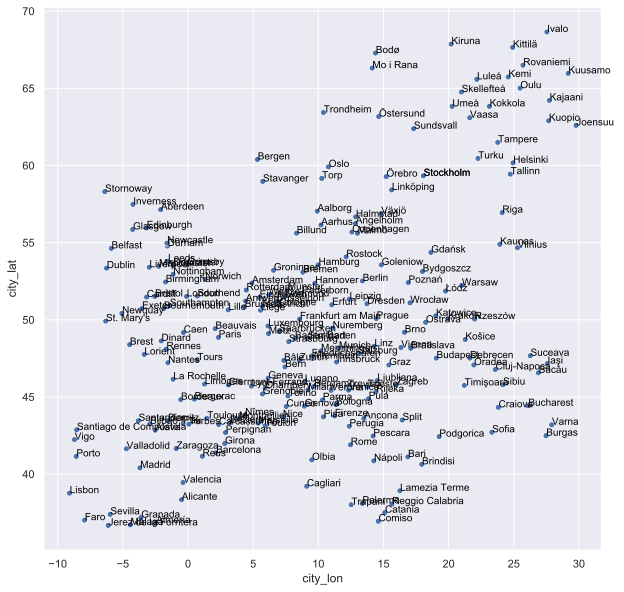

In [164]:
seaborn.set()
plt.figure(figsize=(10,10))
scatter = seaborn.scatterplot(x=cities.city_lon, y=cities.city_lat)

for line in range(0,cities.shape[0]):
     scatter.text(cities.city_lon[line]+0.02, cities.city_lat[line], 
     cities.name[line], horizontalalignment='left', 
     size='small', color='black', weight='normal')

Well, that certainly looks like Europe.

Let's try a fancier visualisation...

In [168]:
fig = go.Figure(go.Scattermapbox(
        lat=cities['city_lat'],
        lon=cities['city_lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=0.5
        ),
        hovertext=cities['name'],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=MAPBOX_ACCESS_TOKEN,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=49,
            lon=6
        ),
        pitch=0,
        zoom=4
    )
)

fig.show()

By looking at the missing airports, we can take a look at where we've run into issues:

In [187]:
cities_nm = pd.read_sql('cities', con=engine)
cities_nm = cities_nm.astype({'city_lon': float, 'city_lat': float})
cities_nm = cities_nm[pd.isnull(cities_nm['distance'])]
cities_nm

,name,id,airport_lon,airport_lat,city_lon,city_lat,distance
3,Ajaccio,None,8.802920,41.923599,NaN,NaN,NaN
4,"Alajero, La Gomera Island",None,-17.214600,28.029600,NaN,NaN,NaN
6,Alexandroupolis,None,25.956301,40.855900,NaN,NaN,NaN
7,Alghero,None,8.290770,40.632099,NaN,NaN,NaN
10,Alstahaug,None,12.468900,65.956802,NaN,NaN,NaN
...,...,...,...,...,...,...,...
330,Zakynthos Island,None,20.884300,37.750900,NaN,NaN,NaN
332,Zemunik,None,15.346700,44.108299,NaN,NaN,NaN
335,Ålesund,None,6.119700,62.562500,NaN,NaN,NaN
336,Årø,None,7.262500,62.744701,NaN,NaN,NaN


In [189]:
fig = go.Figure(go.Scattermapbox(
        lat=cities_nm['airport_lat'],
        lon=cities_nm['airport_lon'],
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=10,
            opacity=0.5
        ),
        hovertext=cities_nm['name'],
    ))

fig.update_layout(
    hovermode='closest',
    mapbox=go.layout.Mapbox(
        accesstoken=MAPBOX_ACCESS_TOKEN,
        bearing=0,
        center=go.layout.mapbox.Center(
            lat=49,
            lon=6
        ),
        pitch=0,
        zoom=4
    )
)

fig.show()

The key coverage gaps here are:
- Islands
- Outside European continent
- Greece
- Norway

Next step: we need to grab those all-important journey times... we're going to create a new view which has all the data that we will want to send back to the Hafas API to get the journey times.

In [83]:
cur.execute("DROP TABLE IF EXISTS journey_times")
cur.execute("""CREATE TABLE journey_times AS
SELECT t1.orig_city, t1.dest_city, t1.pas, t2.id AS orig_id, t3.id AS dest_id FROM airdemand t1
  INNER JOIN cities t2 ON t1.orig_city=t2.name
  INNER JOIN cities t3 ON t1.dest_city=t3.name
  WHERE t2.id NOTNULL AND t3.id NOTNULL;""")

Ok, let's see if we have all the data that we need.

In [84]:
for row in cur.execute("SELECT * FROM journey_times ORDER BY pas DESC LIMIT 5;"):
    print(row)

('Dublin', 'London', 4889549, '6096001', '7096001')
('Amsterdam', 'London', 4485329, '8400058', '7096001')
('Edinburgh', 'London', 3430196, '7000756', '7096001')
('Toulouse', 'Paris', 3247695, '8700065', '8796001')
('London', 'Barcelona', 3113005, '7096001', '7100064')


Now let's add some columns to store the results:

In [85]:
cur.execute("""ALTER TABLE journey_times ADD COLUMN journey_results TEXT""")
cur.execute("""ALTER TABLE journey_times ADD COLUMN journey_time INTEGER""")

In [90]:
while True:
    for orig_city, dest_city, pas, orig_id, dest_id, *_ in cur.execute("""
    SELECT * FROM journey_times WHERE journey_results IS NULL ORDER BY pas DESC LIMIT 5;""").fetchall():
        print(f"Making request for {orig_city}, {dest_city}")
        result = journey(orig_id, dest_id)
        print("Request done...")
        
        cur.execute("UPDATE journey_times SET journey_results = ? WHERE orig_id = ? AND dest_id = ?;", (json.dumps(result), orig_id, dest_id))
        con.commit()

Making request for Helsinki, Stockholm
Request done...
Making request for Cagliari, Rome
Request done...
Making request for Helsinki, London
Request done...
Making request for Helsinki, Copenhagen
Request done...
Making request for Cagliari, Milan
Request done...
Making request for Helsinki, Amsterdam
Request done...
Making request for Olbia , Milan
Request done...
Making request for Frankfurt am Main, Helsinki
Request done...
Making request for Oslo, Helsinki
Request done...
Making request for Berlin, Helsinki
Request done...
Making request for Paris, Helsinki
Request done...
Making request for Bergamo, Cagliari
Request done...
Making request for Kaunas, London
Request done...
Making request for Olbia , Rome
Request done...
Making request for Rome, Sofia
Request done...
Making request for Tallinn, Helsinki
Request done...
Making request for Riga, Stockholm
Request done...
Making request for Berlin, Riga
Request done...
Making request for Frankfurt am Main, Tallinn
Request done...
Maki

Request done...
Making request for Växjö, Stockholm
Request done...
Making request for Bergamo, Riga
Request done...
Making request for Nîmes, London
Request done...
Making request for Eindhoven, Nice
Request done...
Making request for Stavanger, Torp
Request done...
Making request for Newcastle, Barcelona
Request done...
Making request for Nuremberg, Vienna
Request done...
Making request for Katowice, Doncaster
Request done...
Making request for Dublin, Nápoli
Request done...
Making request for Beauvais, Vilnius
Request done...
Making request for Bucharest, Oradea
Request done...
Making request for Weeze, Bergamo
Request done...
Making request for Bari, Budapest
Request done...
Making request for Paris, Belfast
Request done...
Making request for Amsterdam, Ljubljana
Request done...
Making request for Faro, Hamburg
Request done...
Making request for Madrid, Catania
Request done...
Making request for Birmingham, Berlin
Request done...
Making request for Bucharest, Nápoli
Request done...

KeyboardInterrupt: 

In [89]:
cur.execute("UPDATE journey_times SET journey_results = NULL WHERE journey_results = 'null';")
con.commit()

In [91]:
for orig_city, dest_city, pas, orig_id, dest_id, journey_results, journey_time in cur.execute("""
SELECT * FROM journey_times WHERE NOT journey_results IS NULL;""").fetchall():
    journey_results_dict = json.loads(journey_results)
    total_times = []
    try:
        for result in journey_results_dict:
            leg_times = [(leg['departure'], leg['arrival']) for leg in result['legs']]
            try:
                leg_times = [ciso8601.parse_datetime(leg_time[1]) - ciso8601.parse_datetime(leg_time[0]) for leg_time in leg_times]
            except TypeError:
                break
            total_times.append(sum([x.seconds for x in leg_times]))
    except TypeError:
        pass
    print(total_times) # just to check that it's reading everything from the db OK
    try:
        total_time = min(total_times)
    except ValueError:
        total_time = None
    cur.execute("UPDATE journey_times SET journey_time = ? WHERE orig_id = ? AND dest_id = ?;", (total_time, orig_id, dest_id))
    con.commit()

[40380, 40380, 39660]
[15420, 17760, 18120]
[53100, 56100, 52560]
[117180, 112620, 112620]
[45360, 48600, 42660]
[10080, 11400, 10080]
[58380, 48360, 46920]
[42840, 42780, 44220]
[53340, 26940, 27420]
[27720, 28200, 32040]
[43680, 42300, 43620]
[14940, 14820, 16380]
[48240, 47880, 52140]
[22740, 24480, 24300]
[29520, 26460, 30180]
[19380, 19980, 24180]
[28740, 29580, 33960]
[40740, 36300, 35280]
[33660, 40320, 37020]
[]
[62160, 70200, 70080]
[58620, 60300, 61440]
[54900, 53820, 52200]
[56340, 55260, 54000]
[16020, 20760, 29820]
[50280, 50580, 49500]
[120780, 91020, 89940]
[82020, 80940, 61380]
[153060, 153060, 151980]
[31980, 42300, 30240]
[93360, 90120, 107580]
[68280, 65040, 65040]
[72000, 68760, 68220]
[84120, 83040, 81780]
[66720, 63480, 69480]
[49620, 50640, 52500]
[51720, 54300, 54540]
[68700, 65460, 71580]
[56700, 57240, 59580]
[92940, 89700, 109680]
[67440, 64200, 70500]
[106920, 86220, 85140]
[74340, 73260, 61920]
[82560, 79320, 95820]
[58320, 57240, 60900]
[72120, 68880, 7128

[80580, 71760, 76020]
[83040, 65280, 61260]
[138480, 138480, 138480]
[89520, 105060, 92940]
[189960, 190800, 189960]
[68160, 50580, 66000]
[65760, 66120, 66960]
[98880, 100140, 95100]
[]
[74040, 52920, 52020]
[115680, 115560, 86280]
[118740, 115860, 116700]
[69540, 68640, 82620]
[47280, 41340, 42240]
[49860, 50700, 52560]
[84360, 85440, 84360]
[68700, 71580, 58140]
[119820, 97920, 99120]
[92040, 86280, 91380]
[]
[]
[23520, 24780, 23760]
[47700, 51300, 50220]
[45900, 47940, 53100]
[25680, 26880, 24720]
[48840, 50040, 50100]
[]
[]
[]
[]
[]
[]
[]
[40440, 41880, 34260]
[67140, 68820, 40740]
[53280, 50160, 56640]
[46740, 41880, 44220]
[49080, 41640, 41460]
[29520, 38160, 31440]
[109140, 98940, 109440]
[49620, 52920, 62760]
[87660, 81300, 83220]
[]
[26520, 26520, 36540]
[67860, 69540, 39900]
[75420, 63120, 68160]
[15180, 15480, 22920]
[59520, 52080, 50640]
[15540, 15480, 16080]
[46080, 47520, 39900]
[59400, 52020, 51780]
[51180, 49080, 44820]
[]
[34320, 34320, 32820]
[102600, 102600, 107760]

[54240, 53580, 53640]
[94860, 97200, 88440]
[89820, 90420, 103620]
[45480, 44760, 35760]
[159660, 152880, 152880]
[46200, 47640, 35880]
[9420, 8820, 9480]
[47220, 51600, 35160]
[41940, 41280, 37920]
[134280, 134280, 134280]
[129840, 129840, 129840]
[117720, 117720, 117720]
[102480, 116880, 102480]
[128760, 128760, 128760]
[160020, 154800, 145980]
[169560, 163920, 155460]
[184320, 178560, 184320]
[113160, 116160, 113160]
[129300, 129300, 129300]
[117060, 117060, 117060]
[127380, 127380, 127380]
[99120, 97620, 97620]
[38340, 36180, 33660]
[73740, 101760, 100260]
[55380, 77640, 53160]
[40500, 33900, 33600]
[68520, 72960, 81480]
[46020, 45660, 45720]
[46020, 49440, 46860]
[84660, 91080, 78120]
[48420, 24000, 23760]
[43860, 44880, 44040]
[38880, 42300, 39420]
[55500, 56220, 58980]
[30960, 48180, 47220]
[]
[22440, 22560, 18840]
[83340, 89760, 77340]
[34860, 34560, 40560]
[70560, 66360, 75420]
[78360, 81540, 77460]
[27600, 27300, 31740]
[64860, 45360, 48120]
[48060, 28680, 31440]
[61080, 3858

[106920, 107460, 108000]
[106560, 99180, 99180]
[101940, 100680, 99540]
[106200, 106200, 106200]
[]
[98640, 98640, 98640]
[77160, 77160, 77160]
[20580, 22200, 24000]
[91500, 90180, 89760]
[99120, 99120, 99120]
[97260, 97380, 97260]
[101640, 111900, 99180]
[52620, 32820, 36780]
[51480, 58980, 49500]
[77460, 61260, 68760]
[39360, 37800, 33120]
[39780, 44520, 37680]
[5700, 5820, 5820]
[19800, 21660, 22860]
[15720, 19740, 19740]
[53760, 55200, 54600]
[19620, 22140, 20580]
[44220, 41520, 36000]
[40800, 35280, 39240]
[13680, 14940, 15780]
[9180, 10500, 8940]
[]
[21960, 26040, 25800]
[71880, 69180, 63960]
[43800, 48060, 46500]
[]
[50100, 55620, 51840]
[77400, 57180, 54480]
[11880, 12420, 11820]
[24240, 33120, 24540]
[81900, 92280, 88260]
[36720, 47820, 45600]
[20820, 24720, 24300]
[14040, 12780]
[24900, 20940, 28260]
[55680, 52980, 49860]
[32100, 31500, 36000]
[31680, 27720, 34680]
[29640, 24480, 26580]
[35460, 32760, 33000]
[12660, 12840, 12420]
[66780, 64080, 59940]
[11100, 9240, 14220]
[43

[52020, 38100, 38460]
[44580, 52080, 37860]
[25860, 50580, 29700]
[33480, 33840, 34620]
[57300, 58740, 56280]
[21360, 23040, 22500]
[11580, 10740, 11400]
[20820, 19860, 17460]
[35340, 35520, 35460]
[36360, 32880, 33000]
[60480, 67980, 56160]
[52320, 28020, 23700]
[]
[84240, 79080, 79380]
[91440, 94200, 101400]
[8400, 8460, 9180]
[51660, 32460, 35220]
[68700, 71460, 49980]
[59160, 61800, 62700]
[57540, 50040, 50460]
[134580, 134700, 134580]
[75180, 75720, 75720]
[49800, 72060, 47580]
[43500, 75900, 44520]
[]
[41460, 43140, 41400]
[128520, 158340, 139740]
[58080, 51960, 62880]
[15300, 37860, 12420]
[]
[80580, 74040, 88680]
[40680, 38220, 70080]
[56700, 57240, 57240]
[73800, 72540, 74640]
[55800, 56520, 54060]
[105240, 102180, 104700]
[158040, 152820, 144000]
[94140, 93540, 88380]
[]
[79440, 98820, 68940]
[75240, 73500, 73500]
[23100, 24660, 24660]
[112740, 117420, 120000]
[]
[49500, 33000, 31560]
[77400, 84060, 83280]
[50580, 58080, 32400]
[89640, 84480, 84780]
[42540, 29400, 29220]
[171

[]
[]
[84840, 88740, 84660]
[109200, 102900, 109200]
[61860, 64680, 42780]
[72660, 64380, 77520]
[100200, 105840, 106200]
[61740, 61140, 56700]
[87600, 79380, 96000]
[80460, 73680, 84240]
[]
[69420, 70260, 62340]
[111780, 107160, 112560]
[106080, 111120, 101460]
[36360, 54480, 35820]
[55500, 60900, 67260]
[87240, 73440, 78480]
[15000, 27600, 16320]
[54600, 49140, 48540]
[]
[37920, 44160, 35580]
[71460, 61320, 75000]
[15600, 13080, 14340]
[11880, 17700, 23400]
[50280, 45660, 54420]
[119760, 124800, 121560]
[84360, 85980, 81240]
[55680, 50340, 54540]
[42000, 26400, 29100]
[34740, 42300, 41760]
[34140, 37500, 34380]
[87180, 87120, 88620]
[28260, 28260, 28380]
[49980, 49440, 47160]
[59400, 58740, 52860]
[44700, 40500, 40680]
[17520, 34080, 17280]
[78420, 79500, 64320]
[8760, 8520, 9360]
[29880, 26280, 26760]
[24600, 23820, 24480]
[128040, 100860, 118080]
[68820, 79080, 75240]
[30900, 35700, 31740]
[27780, 34920, 28800]
[17100, 16920, 15120]
[75420, 73920, 81060]
[48540, 48180, 58020]
[5178

In [93]:
df = pd.read_sql("""SELECT t1.orig_city AS orig_city, t1.dest_city AS dest_city, t1.pas AS pas,
                    t1.orig_lat, t1.orig_lon, t1.dest_lat, t1.dest_lon, t2.journey_time FROM airdemand t1
                    INNER JOIN journey_times t2 ON t1.orig_city = t2.orig_city AND t1.dest_city = t2.dest_city""",
                 con=engine)
# df.dropna(inplace=True)
# df = df.astype({'pas_crd': int, 'journey_time': int})
# df['journey_time'] = df['journey_time']/3600
# df['label'] = df['orig_city'] + "-" + df['dest_city']
# df.reset_index(inplace=True)

In [94]:
df['journey_time_hrs'] = df['journey_time']/3600
df

,orig_city,dest_city,pas,orig_lat,orig_lon,dest_lat,dest_lon,journey_time,journey_time_hrs
0,Aalborg,Amsterdam,209998,57.092759,9.849243,52.308601,4.763890,39660.0,11.016667
1,Aalborg,Copenhagen,851367,57.092759,9.849243,55.617901,12.656000,15420.0,4.283333
2,Aalborg,London,39969,57.092759,9.849243,51.148102,-0.190278,52560.0,14.600000
3,Aalborg,Málaga,55561,57.092759,9.849243,36.674900,-4.499110,112620.0,31.283333
4,Aalborg,Oslo,28160,57.092759,9.849243,60.193901,11.100400,42660.0,11.850000
...,...,...,...,...,...,...,...,...,...
2112,Weeze,Växjö,20423,51.602402,6.142170,56.929100,14.728000,43140.0,11.983333
2113,Wrocław,Warsaw,526530,51.102699,16.885799,52.165699,20.967100,15660.0,4.350000
2114,Zagreb,Warsaw,49044,45.742901,16.068800,52.165699,20.967100,51480.0,14.300000
2115,Zurich,Warsaw,272322,47.464699,8.549170,52.165699,20.967100,51180.0,14.216667


In [95]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df["journey_time_hrs"],
    y=df["pas"],
    hovertext=df['orig_city'] + "-" + df['dest_city'],
    hoverinfo="text",
    showlegend=False,
    mode="markers"
))

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Journey time (hrs)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Air passengers carried (annual)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.update_yaxes(type="log")

There's a nice picture! We should really focus this down on those routes with, say, in excess of 1m passengers.

In [197]:
df_hi = df[df['pas']>10**6]
df_hi.to_json('df_hi_full.json', orient='records')

In [181]:
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=df_hi["journey_time_hrs"],
    y=df_hi["pas"],
    hovertext=df_hi['orig_city'] + "-" + df_hi['dest_city'],
    hoverinfo="text",
    showlegend=False,
    mode="markers"
))

fig.update_layout(
    xaxis=go.layout.XAxis(
        title=go.layout.xaxis.Title(
            text="Journey time (hrs)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    ),
    yaxis=go.layout.YAxis(
        title=go.layout.yaxis.Title(
            text="Air passengers carried (annual)",
            font=dict(
                family="Helvetica",
                size=18,
                color="#7f7f7f"
            )
        )
    )
)

fig.update_yaxes(type="log")

What's interesting is how many of these corridors actually have journeys less than 5 hours! See this list:

In [195]:
out = df_hi[df_hi['journey_time_hrs']<5].sort_values('pas', ascending=False)
out = out[['orig_city', 'dest_city', 'pas', 'journey_time']].to_json('df_hi.json', orient='records')

But this isn't really what we're interested in. Let's take a look at journeys between 8 and 15 hours, which are more optimal for sleeper services.

In [198]:
df_long = df_hi[df_hi['journey_time_hrs']>8][df_hi['journey_time_hrs']<15]
df_long.reset_index(inplace=True)

/Users/keelan/.local/share/virtualenvs/hsr-feasibility-ld64pNQS/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



In [200]:
df_long

,index,orig_city,dest_city,pas,orig_lat,orig_lon,dest_lat,dest_lon,journey_time,journey_time_hrs
0,55,London,Alicante,1469812,51.874699,-0.368333,38.282200,-0.558156,53700.0,14.916667
1,89,Amsterdam,Barcelona,1361453,52.308601,4.763890,41.297100,2.078460,38820.0,10.783333
2,108,Amsterdam,Copenhagen,1033488,52.308601,4.763890,55.617901,12.656000,38760.0,10.766667
3,111,Amsterdam,Dublin,1080890,52.308601,4.763890,53.421299,-6.270070,49680.0,13.800000
4,140,Amsterdam,Madrid,1021986,52.308601,4.763890,40.471926,-3.562640,50220.0,13.950000
5,143,Amsterdam,Milan,1193517,52.308601,4.763890,45.445099,9.276740,47700.0,13.250000
6,228,Brussels,Barcelona,1017360,50.459202,4.453820,41.297100,2.078460,32040.0,8.900000
7,255,London,Barcelona,3113005,51.884998,0.235000,41.297100,2.078460,35220.0,9.783333
8,277,Rome,Barcelona,1222627,41.800278,12.238889,41.297100,2.078460,51720.0,14.366667
9,368,London,Belfast,2505627,51.505299,0.055278,54.618099,-5.872500,34020.0,9.450000


In [199]:
df_long.sort_values('pas', ascending=False)
df_long.to_json('df_long.json', orient='records')

In [104]:
fig = go.Figure()
for i in range(len(df_hi)):
    fig.add_trace(
        go.Scattergeo(
            lon = [df_hi['orig_lon'][i], df_hi['dest_lon'][i]],
            lat = [df_hi['orig_lat'][i], df_hi['dest_lat'][i]],
            mode = 'lines',
            line = dict(width = 1,color = 'red')
        )
    )

for x in ['orig', 'dest']:
    
    fig.add_trace(
        go.Scattergeo(
        lon = df_hi[f'{x}_lon'],
        lat = df_hi[f'{x}_lat'],
        hoverinfo = 'text',
        text = df_hi[f'{x}_city'],
        mode = 'markers',
        marker ={'color':'black'}
        ))

fig.update_layout(
    title_text = 'Busiest European air corridors',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'europe',
        projection_type = 'azimuthal equal area',
        showland = True,
        landcolor = 'rgb(243, 243, 243)',
        countrycolor = 'rgb(204, 204, 204)',
    ),
)

fig.show()

Now comes the fun stuff - let's take a look at planning some routes!

There's clearly some clustering here around a few cities - in particular, London, Amsterdam and Rome. I'm sure there's some fancy route optimisation you could do here, but I'm not really interested in any of that. Let's just choose some relatively obvious routes.

In [206]:
routes = [
{'pm':["Madrid", "Barcelona"], 'am': ["Brussels", "Rotterdam", "Amsterdam"]},
{'pm':["Madrid", "Barcelona"], 'am': ["Frankfurt am Main"]},
{'pm':["Madrid", "Barcelona"], 'am': ["Rome"]},
{'pm':["Madrid", "Barcelona"], 'am': ["Paris"]},

{'pm':["London"], 'am':["Lyon", "Nice"]},
{'pm':["London"], 'am':["Cologne", "Munich"]},
{'pm':["London"], 'am':["Hannover", "Hamburg", "Copenhagen"]},
{'pm':["London", "Brussels"], 'am':["Hannover", "Berlin", "Prague"]},
{'pm':["London", "Brussels"], 'am':["Vienna"]},
{'pm':["London"], 'am':["Lyon", "Montpellier", "Barcelona", "Madrid"], 'am_cxn':["Valencia", "Alicante"]},
{'pm':["London"], 'am':["Lyon", "Torino", "Milan"], 'am_cxn':['Venice']},

{'pm':["Amsterdam"], 'am':["Hamburg", "Copenhagen"]}, 
{'pm':["Amsterdam", "Cologne", "Frankfurt am Main"], 'am':["Milan", "Firenze", "Rome"]},

{'pm':["Paris", "Lyon"], 'am':["Torino", "Milan", "Firenze", "Rome"]},
{'pm':["Paris"], 'am': ['Berlin']},
{'pm':["Frankfurt am Main"], 'am':["Vienna"]}
]

In [212]:
for route in routes:
    tam = 0
    for city1 in route['pm']:
        for city2 in route['am']:
            try:
                index, pas, *_ = con.execute("""
                SELECT * FROM airdemand WHERE (orig_city LIKE ? AND dest_city LIKE ?) OR
                (orig_city LIKE ? AND dest_city LIKE ?) LIMIT 1;""",
                                             (city1, city2, city2, city1)).fetchall()[0]
            except IndexError:
                pas = 0
            tam += pas
    route['tam'] = tam

In [213]:
routes

[{'pm': ['Madrid', 'Barcelona'],
  'am': ['Brussels', 'Rotterdam', 'Amsterdam'],
  'tam': 4632868},
 {'pm': ['Madrid', 'Barcelona'], 'am': ['Frankfurt am Main'], 'tam': 1974858},
 {'pm': ['Madrid', 'Barcelona'], 'am': ['Rome'], 'tam': 2701683},
 {'pm': ['Madrid', 'Barcelona'], 'am': ['Paris'], 'tam': 4672397},
 {'pm': ['London'], 'am': ['Lyon', 'Nice'], 'tam': 2013951},
 {'pm': ['London'], 'am': ['Cologne', 'Munich'], 'tam': 2287069},
 {'pm': ['London'],
  'am': ['Hannover', 'Hamburg', 'Copenhagen'],
  'tam': 3567027},
 {'pm': ['London', 'Brussels'],
  'am': ['Hannover', 'Berlin', 'Prague'],
  'tam': 4516268},
 {'pm': ['London', 'Brussels'], 'am': ['Vienna'], 'tam': 1571000},
 {'pm': ['London'],
  'am': ['Lyon', 'Montpellier', 'Barcelona', 'Madrid'],
  'am_cxn': ['Valencia', 'Alicante'],
  'tam': 6838868},
 {'pm': ['London'],
  'am': ['Lyon', 'Torino', 'Milan'],
  'am_cxn': ['Venice'],
  'tam': 3315012},
 {'pm': ['Amsterdam'], 'am': ['Hamburg', 'Copenhagen'], 'tam': 1487728},
 {'pm': [

In [233]:
for route in routes:
    route['evening_stops'] = ', '.join(route['pm'])
    route['morning_stops'] = ', '.join(route['am'])
    route['required_market'] = 500*365/route['tam']
    city1, city2 = route['pm'][0], route['am'][-1]
    *_, journey_time = con.execute("""
                SELECT * FROM journey_times WHERE (orig_city LIKE ? AND dest_city LIKE ?) OR
                (orig_city LIKE ? AND dest_city LIKE ?) LIMIT 1;""",
                                             (city1, city2, city2, city1)).fetchall()[0]
    route['journey_time'] = journey_time

In [235]:
routes2 = [{'evening_stops': route['evening_stops'],
            'morning_stops': route['morning_stops'],
            'tam': route['tam'],
            'required_market': route['required_market'],
            'journey_time': route['journey_time']} for route in routes]
with open('routes.json', 'w+') as f:
    json.dump(routes2, f)

In [150]:
cities_table = pd.read_sql('cities', con=engine)
cl_pd = pd.DataFrame(city_li, columns=['name'])

In [151]:
cl_pd.merge(cities_table, how='left', on='name', indicator=True)

,name,id,airport_lon,airport_lat,city_lon,city_lat,distance,_merge
0,Prague,5496001,14.260000,50.100800,14.451481,50.081926,13.862229,both
1,Firenze,8396001,11.205100,43.810001,11.249928,43.765835,6.090993,both
2,Nuremberg,8096025,11.078056,49.498699,11.077955,49.450748,5.333064,both
3,Lyon,8796002,5.081111,45.725556,4.863811,45.702255,17.116373,both
4,Paris,8796001,2.379444,48.723333,2.333681,48.861496,15.728114,both
5,London,7096001,-0.461941,51.470600,-0.113272,51.518456,24.793082,both
6,Vienna,8196001,16.569700,48.110298,16.341553,48.207037,20.094759,both
7,Munich,8000261,11.786100,48.353802,11.558744,48.140364,29.126982,both
8,Rotterdam,8400530,4.437220,51.956902,4.468771,51.924804,4.178843,both
9,Venice,8396008,12.351900,45.505299,12.315491,45.444427,7.339980,both
